In [1]:
import os
import dharpa
from rich.jupyter import print
from dharpa import DHARPA_TOOLBOX_DEFAULT_WORKFLOWS_FOLDER
from dharpa.graphs.utils import graph_to_image
from dharpa.utils import get_data_from_file

# Context & Requirements

## Types of data

- scalars (mostly user inputs, booleans, strings, enums, numbers)
- lists of items of the same type
- tabular data (a collection of lists of items of the same type, each with the same number of items, incl. schema)
- binary data: images, videos, audio files

In our application, we'll deal with a few basic types of data:

- scalars (mostly user inputs, booleans, strings, enums, numbers)
- lists of items of the same type
- tabular data (a collection of lists of items of the same type, each with the same number of items, incl. schema)
- binary data: images, videos, audio files

*Sidenote*: I consider every kind of user input as data, since it is conceptually the same thing and needs to be recorded and managed the same way.

For our purpose, we can ignore scalars because they are easy and cheap to handle, and can be attached to any sort of data or metadata in a few different ways. Also, let's ignore binary data for now, while acknowledging that we will need a strategy to deal with efficiently, in a way that is not too different from how we deal with other types.

Which leaves us with lists and tabular data. Those are different to scalars, because there is no telling in advance how many rows they will have, and how large its cells will be (aka 'how many bytes are we dealing with, KBs, MBs, GBs, TBs?'). List (arrays) will be our main data type, along with tables (dataframes) -- the latter are really just lists of lists (including a schema/description of the type of each list). In a lot of cases a module will receive a table, and the output will be a list of the same length as the table. When using Pandas, we usually assign dataframes to variables, this is handy because we have access to the whole dataset via a single variable, and can access the columns seperately via their names. For our case, because we will have connected modules, we will probably deal with 2 scenarios:

- a module changes the data in a dataframe in one or several columns: this will be rare, but in this case the result of such a module will be a new dataframe
- a module adds one or several column to a dataset: this is much more common. It doesn't make much sense to have dataframes as outputs in this case, since those would contain the same data as the input. There is no need to allocate double the amount of memory, for an exact copy of something we already have available (for read purposes). So, in those cases the output will be one or several lists, with the same amount of rows as the input dataframe. Those lists can then be easily assembled into a dataframe at a later stage, if the need arises.


## Requirements

Since data will be the central object our application handles, we need to decide on an internal (as well as import/export) data format. The obvious thing to do would be to use the most common format (probably json), and just use that. For several reasons (layed out in the [data_formats document](data_formats.ipynb)), I don't think this is a good idea in our case. I think we can anticipate our main requirements on a data format before writing any code, which is why I created this document: to list those requirements, and to come up with a recommendation that is based upon them.

### Technical requirements

- schema-aware (ideally included in the format)
- binary format (performance, filesize)
- column-based (for tabular data -- analytics query performance)
- zero-copy, memory-mapping
- compression in-build (preferrable)
- possible to use from different programming languages (at least Python & JS)
- as little cpu, memory, and disk utilization as possible


The first group of requirements is technical: we are creating an interactive application, which means we should at least spend some time optimizing for speed (in those instances where it's possbile). In addition: the more we know about our data and its 'shape', the less complex our code has to be, since that removes the need for investigating and validating data at multiple points along its journey.

The latter can be achieved by using a data format that is schema aware (e.g. not csv), and ideally includes that schema as metadata in its specification, so we can query the data(-bytes) directly, without having to read seperate, external specifications.

For the performance requirements, it's fairly easy to see why we should be looking for a binary, column-based format, that ideally has extra features like memory-mapping and compression.

Last but not least we want to be able to access our data from different programming languages. Python and JavaScript support will be mandatatory, but being able to read from Julia and R would also be highly desirable.


### General requirements

- option to attach metadata
- versioning of datasets
- versioning of metadata
- we want to be able to treat all data the same way, independent of size, format, other characteristics
- we want all of this to be more or less transparent to our end-users!

Because it's in the nature of our application that we won't exactly know hob big and what shape the data we will be dealing with will have, we have to anticipate a wide range of types and sizes. In order to not have to deal with those differentely each time, it would be highly adventageous if we can come up with a standard 'interface' for our datasets, that lets us, as a minimum, query minimal required metadata (schema, authors, size), and which allows us to forward the dataset to other parts of our application (other modules, frontend), without having to convert or serialize/deserialize it.

Most importantly, we will have to figure out a way to make most of this transparent to users. This is probably nothing a data format can help us with directly, but there might be factors in the periphery which can make this easier, or harder (e.g.: how common is that data-format, how much tooling exists for it?)

One of our main requirements is to be able to easily attach metadata to our datasets. In addition we want it to be as easy as possible to 'version' the containing data, as well as the attached metadata. Those requirements stem from the need for good research data practices, and should not need further explanation. Let's look at those two points in a bit more detail:

#### Technical metadata (automatic)
  - data type
  - schema (if tabular data)
  - statistics on columns, rows (number of rows, min in column, max in column)
  - data specific indicators/summaries (e.g. geographic range, resolution, ...)
  - digest / checksum (unique id!)

The most important metadata we'll be dealing with is the type of data, and its schema in case its in tabular form. As was mentioned above, ideally this would be forced and included by/in the data format we choose, so we can rely on it to be available, always.
In addition, in a lot of cases it aids performance if certain characteristics of a dataset are known without having to actually touch it. One example would be min/max values for numeric columns. Geographic range, resolution could be interesting for location data, creation date for photos, and so on.
A special item of metadata is a checksum: that enables us to confirm the bytes of a dataset haven't changed since we last checked, and it also makes things like caching or lookups easier.
All of those metadata items can be created more or less automatically, without any user input. This is important to differentiate, because that means we don't need to worry about providing a user-interface so they can be added/attached.


  
#### Other metadata (requires user input)
  - provenance / lineage / heritage
  - author(s)/creator(s) incl. contact info
  - creation / modification date
  - comments, annotations
  - "ALL THE METADATA" (Angela R. Cunningham, PhD)

The second category of metadata is defined by the necessity for manual user input (at least in parts). Which of course means we need to somehow provide a metadata editing facility for those items. Authorship information as well has the provenance-related metadata is arguably the most important one here. But I imagine we'll come up with quite a few more metadata fields we will want to be able to attach. It's probabaly a good idea to talk to our colleagues who develop Zotero and Tropy for some input in this regard.

## Dataset versioning

- versioning of the 'actual' data:
  - new data added
  - existing data changed/fixed
  - existing data removed
- metadata versioning:
  - independent of actual data changes (except for last modification dates, new authors added, checksum)
  - new metadata added
  - existing metadata changed/fixed
  - metadata removed
  - no new dataset version necessary


Data versioning is usually a bit overlooked (although that seems to be changing now, and there are some 'git for data' services and tools cropping up). But it's crucial for good data practices.

In order to always know how result data was created, we need to know exactly which inputs were used, and what exactly was done to them. If any of the inputs changes, and we don't record it, then there will be confusion later, when someone tries to recreate a result with the changed input.

This implies we have a way to point to datasets using some sort of identifier, something like a DOI -- but it does not need to be globally unique, just locally (unless the data gets shared/exported).



## Contexts in which we handle data

- 'onboarding' data:
   - external data gets fed into a workflow / into our app
   - we store a copy internally (to prevent changes we are not aware of)
   - some minimal metadata needs to be provided (but can be at least partly determined automatically)
   - gets unique id / alias(es) & checksum & version '1'
- internal data transformation & transfer:
   - each module processes input data and creates output data
   - output data gets fed into the input of another module
   - input/output data is requested by frontend for display purposes (viz, statistics, table-view, ...)
- exporting data:
   - researcher needs data in a specific format (csv, Excel, json...) for further processing, publishing, etc.

Along with listing requirements, it makes sense to think about in which contexts we deal with data, and how. I think we can seperate three main areas:

- data onboarding
- internal data transformation & transfer
- data export

For the first and last items the 'interface' of the data is important, which means we are concerned about how to translate external dataformat into our internal one, as well as the other way around. For the second item we only deal with our internal format, so performance and code complexity are more important considerations.

For data onboarding, one thing is important is that we store a copy of the dataset the user points us to in a space where we can be sure the data doesn't get changed by external means. We would also add some automatic metadata, and might or might not require the user to provide some basic required metadata-fields manually. We would also give a newly onboarded dataset a version '1' (or maybe '1.0').

Data export is the least problematic area: since we have a minimal set of required metadata for every piece of data we use internally, it should be fairly trivial to export it into any viable export format (csv, excel, json, parquet,...).

Data onboarding and export could also be combined in some scenarios: for example if we don't provide a tool to 'clean' up data (or do something else that would require a version change on the dataset) and users would have to do it externally, we could export the dataset into a temporary folder, let the user do their thing, and then re-import the changed dataset into a new version of the existing, internal one, copying the existing metadata with some additions that describe what was done to the data.

# Solution proposal

## Apache Arrow

- binary, column-based, language-independent in-memory format
- well defined schema and data types, rudimentary custom metadata support
- native support for 2 on-disk formats:
  - feather (same as in-memory format), parquet
- client implementations for most relevant languages
- growing ecosystem:
  - Arrow Flight (fast data transport framework)
  - Plasma (In-Memory object store)
  - Vaex (native support for memory-mapped feather files, memory-mapped querying)
  - duckdb (column-based, python-native sql engine)
  - easy import/export to NumPy/Pandas types (Arrays, DataFrames) -- still some serialization cost
- likely to be the standard format for data exchange in data science/data engineering in the future

In my research, [Apache Arrow](https://arrow.apache.org/) came closest to match our technical requirements, and should let us implement most of the other ones too. It is a binary, column based in-memory format that comes with implementations in a number of programming languages (incl. the ones we are interested in).

From the Arrow website:

> Apache Arrow is a software development platform for building high performance applications that process and transport large data sets. It is designed to both improve the performance of analytical algorithms and the efficiency of moving data from one system or programming language to another.
>
> A critical component of Apache Arrow is its in-memory columnar format, a standardized, language-agnostic specification for representing structured, table-like datasets in-memory. This data format has a rich data type system (included nested and user-defined data types) designed to support the needs of analytic database systems, data frame libraries, and more.

In addition to the efficient in-memory format, it supports 2 on-disk formats: feather & parquet. The former one is basically the same as the in-memory format (with all the advantages that come with that), and the latter is a fairly standard format to exchange large(-ish) datasets between processes and infrastructure components.

In my opinion (and I'm not alone), Arrow will be the de-facto standard data format for tabular data in the future, in both data science and data engineering. It is well designed, and a lot of the reasons why it came about line up fairly well with our own requirements (althought, at a different scale obviously). Because of that, there is a rich tooling ecosystem growing around Apache Arrow at the moment, which I think we can expect to satisfy to most of our current and future needs in the near to medium-term future, if not already.

Esp. [vaex](https://vaex.io/) and [duckdb](https://duckdb.org/) look like very interesting developments. Pandas and Numpy import/export is very well supported, and as well optimized as seems possible. [Apache Arrow Flight](https://arrow.apache.org/blog/2019/10/13/introducing-arrow-flight/) and the [Plasma Object store](https://arrow.apache.org/docs/python/plasma.html) look like good contenders that could handle our potential data transport needs in the future.

## Identifying and versioning datasets

- every dataset gets it's unique id (uuid) as well as one or several user-defined and automatic aliases
- a new version of a dataset is created when its data content changes (content can be entirely different)
- a user can 'designate' a new version of data, in some cases it can be done by our application automatically
- versioning of metadata is independent of dataset version
- allows us to discover 'out-of-date' results (via their connected input-ids), and recreating them with updated input dataset
- frontend must be able to list, access and query datasets/inputs/outputs via unique id & version number


It should be obvious that and why we need some sort of (at least internal) unique identifier for each dataset. The main scenario where users will come in touch with such an identifier is when they are asked to choose an input dataset for a module/workflow. It's possible to make that 100% transparent to the user, and let them for example select a folder of csv files, which we would then copy into our internal data repository, assign it an id, and use that for our calculation. That would mean though, that the next time the user wants to use the same dataset again, we would do the same again, basically duplicating our internal dataset. We probably could be smart about it, and recognize those sort of duplicates, but that would involve fairly complex and fragile code I think we should rather avoid, and come up with an interface metaphor/language that makes users aware what is going on, and which empowers them with proper tooling to manage their research data according using best practices (metadata, versioning, etc.).

So, I propose that we should have a 'data management' section in our application UI, which could be used to both 'onboard' and manage datasets independent of a workflow, but also within the context of a workflow (for example by re-using some of the file selection widgets and filling in a newly create dataset id into a workflow input, right after onboarding). How that would look like exactly, we'd have to figure out and I think it would be a work-item on itself.

The same goes for dataset versioning. One way I can imagine this working is to have a ``.<major>.<minor>`` postfix to our unique dataset identifier, where the ``minor`` part gets incremented with every metadata version change, and the ``major`` part for when the actual data changes. Another point to consider is whether to only use version number increases, or also have a concept of 'branching', where the versions of datasets can diverge, from a common parent. I think there is a point to be made for not making things to complicated unless really necessary, so most of this can be solved with a simple versioning scheme, and assigning totally new datasets id if something significant changes in the data of a dataset (while potentially preserving the lineage information by storing the 'parent id' in the new datasets metadata). But, as I said above, I think this would be a good item to investigate independently.

## Storing module results

- requirements: workflow history & snapshots & long running processes
- need for caching of at least the latest results


This section includes a quick recapitulation how our workflows are described and managed by the backend, as well as an outline how to handle and store temporary as well as final workflow outputs. This is important, because having access to already computed results is necessary for some of our requirements (derived from our user-stories):
  - workflow history: enable the user to move back in the history of input sets of a workflow session
  - snapshots: 'tag' certain input sets (basically creating a snapshot of that particular workflow state)
  - support for long running processes: a user will want to have access to computational results, even if the had other workflow sessions inbetween (while a particularly long running job was running)

### Quick recap: workflow modularity

Every module has:
 - one or several named inputs
 - one or several named outputs
 - as well as schema information for each input and output

A workflow is a user-facing entity that:
  - can also be used as a module (has inputs, outputs, schema)
  - contains one or several modules
  - where some inputs of some (internal) modules can be connected to an output of another (internal) module
  - inputs of modules that are not connected to an output of another (internal) module are user inputs

In this example we'll use a workflow that is simlates a ``nand`` logic-gate. Such a logic gate can be created by using ``and`` and ``not`` logic gates one after the other. Below you can see a short description of the modules and their inputs, as well as how that would be configured in a workflow description json file. The important part is the ``modules`` value.

### example module: ``nand``

 - consists of two other modules: 
   - ``and``
      - inputs: ``a`` & ``b`` (booleans)
      - output: ``y`` (boolean - true if both inputs are true, otherwise false)
   - ``not``:
      - input: ``a`` (boolean - connected to ``y`` output of ``and``)
      - output: ``y`` (boolean - negated input)
 - two inputs: ``a`` & ``b`` (booleans, connect directly to ``and`` inputs)
 - one output: ``y`` (false if 'a' & 'b' are true, otherwise true -- connects to ``y`` output of ``not`` module)

In [2]:
print("Module description: [b]nand[/b]")
print(get_data_from_file(os.path.join(DHARPA_TOOLBOX_DEFAULT_WORKFLOWS_FOLDER, "logic_gates", "nand.json")))

After creating the workflow description file, we create the workflow object in code, and for illustration purposes, we display the execution order and the state graph of the workflow (in its inital, stale state without any inputs).

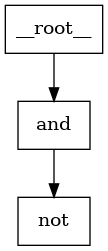

In [3]:
workflow = dharpa.create_workflow("nand")
graph_to_image(workflow.structure.execution_graph)

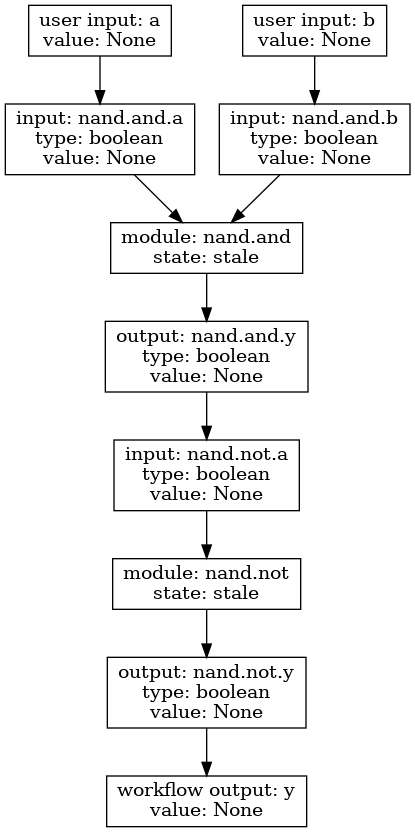

In [4]:
graph_to_image(workflow.create_state_graph(show_structure=True))

Now, we set the inputs (both ``True``, which means the end-result should be ``False``). As you can see from the state graph, the workflow inputs are directly connected to the module inputs of the ``and`` module.

In [5]:
workflow.inputs.a = True
workflow.inputs.b = True

await workflow.process()

processing started: nand.nand
processing started: nand.and
processing finished: nand.and
processing started: nand.not
processing finished: nand.not
processing finished: nand.nand


Again, lets look at the workflow state, this time we display it using a json data structure, not a network graph:

In [6]:
state = workflow.to_dict(include_structure=True)
print(state)

### How to actually deal with workflow/module outputs?

- why not store all results?
- smart way of storing/deleting/managing storage:
  - compression
  - efficient module design
  - cleanup process
  - only store results if good execution time/result size ratio, otherwise just re-process

To satisfy the above mentioned requirements, my current plan is to just store all results of all module runs, instead of coming up with a complicated caching scheme. There will have to be some sort of 'result-cleaning' and consolidation, but I think if we are being smart about it this might be the most promising strategy, which will introduce the least amount of complexity.

A folder structure to accomodate that would probably look something like this:

<img src="result_tree.png">

- each module has its own name/id, all results for a module will be stored under same folder
- 'result.feather' has one or several columns that represent output values
- also, one column with runtime metadata (execution time, version of workflow, etc.)
- this works well with the 'dataset' API in Apache Arrow: https://arrow.apache.org/docs/python/dataset.html (which means we can lazy-load all results of a workflow/module into the same dataframe, and do 'meta'-queries and -analysis on that if we choose to)
- debatable whether 'workflow-results' have to be stored at all, since they are just copies of 'module-results'

In order to not waste too much hard-disk space (which would be the most obvious concern here), I think we have a few different options. For one, we'd store all results with compression enabled. We would implement our modules in an efficient way that is aware of how we store results. We might have a cleanup process running in the background that is aware of how often a result is accessed, and how it's compute-time/result-size ratio is. In some cases where that ratio leans very much towards result-size, we might decide to not store those results at all, but re-process every time.

## Streaming module results

TBD

This is an area I haven't done too much work on yet, but in general: we will want to have access to intermediate results (or, rather: partial results in real-time), so we can provide the user with information they can use to determine whether to cancel a running process or not. Even though we will probably not have that functionality available in our initial, first version, I think we should anticipate that requirement, and design our data management with it in mind, so it can be added later without having to re-write a lot of code.

## Default data format (for import/export)

- every result can be described by specifying:
  - the input dataset(s) and other inputs
  - the workflow (and workflow version) that was used to produce it
  -  -> theoretically, every (result) dataset can be described by very small json file/metadata set
- proposal: invent our own (small) set of file formats (including version-nr, metadata schema, payload)
   - Apache Arrow based for tabular/scalar data
   - folder/zip based for binary data
   - all our import modules would create files in that format
   - provide tooling (and modules) to convert/export those to all common data formats
   - possibility of data registries:
       - very simple implementation compared to products like dataverse, ckan
       - high performance data transfer (using Apache Flight)
       - different levels: local (within our app), organization-wide, global (aka default registry)

The last thing to decide is whether we want to provide a 'standard' data format for our application. This will be modelled closely upon the format we will use internally, but with some added metadata fields and possibly restrictions.

This is mostly for the purpose of sharing, transferring, and publishing data. In principle, there is a really lightweight way to share our work: since we can describe everything we do by specifying the workflow, and listing all the inputs we use with it. Assuming all inputs are either scalars or, in case of datasets, available via download, this description could be very lightweight: it's just a json file containing the workflow structure (incl. maybe version information), and input-data urls. With that, everyone with access to the data can in theory replicate any end- and intermediate result.

In theory, that json structure can also be attached to every result dataset, which means that our results will always come with information how they were produced (and how to re-produce them).

Since all this is very dependent on being able to have access to metadata alongside the 'actual' data, and because in my experience systems and architectures that store metadata seperately to data are either fairly complex, specific and hard to maintain, I would propose we come up with a way to package our data in a way that allows for our metadata to always be included, and where it's easy to access both data and metadata without having to open the whole file. Arrow gets us a long way toward that (for tabular data), the only thing that is missing is a standard way to include metadata. For that we have two options: use the Arrow 'metadata' field (which is fairly limited, it only takes encoded byte-arrays as keys/values), or store our metadata in a seperate column. Currently, I'm leaning toward the latter option, but this is something we'll have to try out and play with to get a better idea how feasable it is.
For other types of data (binary blobs, images, etc.), I propose we use an archive format (zip, tar, ...) with a json file at a standard location (e.g. './.metadata.json') that includes the same metadata schema a tabular dataset would use. That way our datasets always have the same 'interface'. And we can provide a set of standard tools (which could be implemented as workflow modules and workflows) to import and export 'our' data from/to commonly used formats like csv, excel, etc (which in most cases would not include metadata at all).
